In [154]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt 
import psycopg2
import sqlite3
import os
from datetime import datetime
import statsmodels.api as sm

In [172]:
gas_usage=pd.read_csv('/Users/rhl/Downloads/BillingData/gas.csv',skiprows=5)
gas_usage['START_DATE']=pd.to_datetime(gas_usage['START DATE'])
gas_usage['END_DATE']=pd.to_datetime(gas_usage['END DATE'])
gas_usage['USAGE']=gas_usage['USAGE']
gas_usage['COST']=gas_usage['COST'].str.replace('$','').str.replace(',','').astype(float)
gas_usage = gas_usage[['USAGE', 'COST', 'START_DATE', 'END_DATE']]

In [173]:
hdd = pd.read_csv('/Users/rhl/Downloads/hdd.csv',skiprows=6)
hdd.columns = ['DATE','HDD','%EST']
hdd['DATE']=pd.to_datetime(hdd['DATE'])
del hdd['%EST']

In [174]:
gas_usage['key']=1.0
hdd['key']=1.0

In [175]:
df = gas_usage.merge(hdd, on='key', how='outer').query('(START_DATE <= DATE)&(DATE<=END_DATE)').groupby(['USAGE', 'COST', 'START_DATE', 'END_DATE']).agg({'HDD':'sum'}).reset_index()
df['DAYS_IN_PERIOD']=df['END_DATE']-df['START_DATE']
df['MIDDLE_DATE']=df['START_DATE']+df['DAYS_IN_PERIOD']/2.0

In [176]:
df.head()

,USAGE,COST,START_DATE,END_DATE,HDD,DAYS_IN_PERIOD,MIDDLE_DATE
0,6.0,21.07,2018-09-15,2018-09-30,89.9,15 days,2018-09-22 12:00:00
1,8.0,34.55,2019-07-18,2019-08-15,22.0,28 days,2019-08-01 00:00:00
2,8.0,35.33,2019-06-18,2019-07-17,31.4,29 days,2019-07-02 12:00:00
3,8.0,36.36,2019-08-16,2019-09-16,104.6,31 days,2019-08-31 12:00:00
4,10.0,34.44,2017-08-16,2017-09-14,138.8,29 days,2017-08-30 12:00:00


In [177]:
def rng():
    for yr in range(0,3):
        start=(pd.to_datetime('10-15-2017')+pd.Timedelta(yr,'Y')).normalize()
        end=(pd.to_datetime('05-15-2018')+pd.Timedelta(yr,'Y')).normalize()
        yield (start,end)
idx=pd.Series([False]*df.shape[0])
df['HEATING_SEASON']=-1
for x,y in list(rng()):
    maxs = df['START_DATE'].apply(lambda z: max(x,z))
    mins = df['END_DATE'].apply(lambda z: min(y,z))
    df.loc[(maxs < mins),'HEATING_SEASON']=x.year
    idx=np.logical_or(idx,(maxs < mins))
df['IS_HEATING']=df['HEATING_SEASON'].replace(-1,np.nan).notnull()
df['HEATING_SEASON']=df['HEATING_SEASON'].replace(-1,np.nan).fillna(method='bfill').astype(int)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: M and Y units are deprecated and will be removed in a future version.
  after removing the cwd from sys.path.


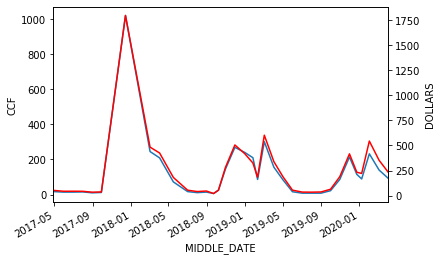

In [178]:
ax=df.set_index('MIDDLE_DATE')['USAGE'].plot()
_=ax.set_ylabel('CCF')
ax=df.set_index('MIDDLE_DATE')['COST'].plot(ax=ax.twinx(),color='r')
_=ax.set_ylabel('DOLLARS')

In [179]:
non_htg=df.query("IS_HEATING==False")
(non_htg['USAGE']/non_htg['DAYS_IN_PERIOD'].dt.days).describe()

count    16.000000
mean      0.528775
std       0.359055
min       0.258065
25%       0.380850
50%       0.467186
75%       0.521025
max       1.785714
dtype: float64

In [180]:
def json_data1():
    for root, dirs, files in os.walk('/Users/rhl/Downloads/NEST_DATA-3/Nest/thermostats'):
        for x in files:
            if 'summary' in x:
                yield os.path.join(root,x)
usage=pd.concat([pd.read_json(x).T for x in json_data1()]).sort_index()
def parse_json(x):
    startTs = pd.to_datetime(x['startTs'],utc=True).tz_convert('America/New_York')
    duration = int(x['duration'][:-1])
    return (startTs, startTs+pd.to_timedelta(duration,'s'),duration)
flatten = lambda l: [parse_json(item) for sublist in l for item in sublist]  
heating_cycle=pd.DataFrame.from_records(flatten(usage['cycles'].values.tolist()),columns=['startTs','endTs','duration'])
heating_cycle['key']=1.0
df['key']=1.0

In [190]:
merged = df.merge(heating_cycle,on='key',how='outer')
merged['START_DATE']=pd.to_datetime(merged['START_DATE']).dt.tz_localize('America/New_York')
merged['END_DATE']=pd.to_datetime(merged['END_DATE']).dt.tz_localize('America/New_York')
merged['START_DT']=merged[['START_DATE','startTs']].max(axis=1)
merged['END_DT']=merged[['END_DATE','endTs']].min(axis=1)
merged = merged.query('START_DT < END_DT')

In [194]:
heating_data = merged.groupby([x for x in df.columns if 'key' not in x])['duration'].sum().reset_index()
heating_data['duration']=heating_data['duration']/3600

In [208]:
heating_data.query('IS_HEATING==True').groupby('HEATING_SEASON')[['USAGE','duration']].sum()

,USAGE,duration
HEATING_SEASON,,
2017,281.0,189.001667
2018,1492.0,2657.550833
2019,876.0,1283.322500


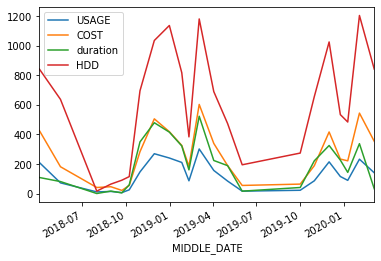

In [216]:
heating_data.sort_values(by=['START_DATE']).set_index('MIDDLE_DATE')[['USAGE','COST','duration','HDD']].plot()

In [220]:
heating_data[['duration','HDD']]

,duration,HDD
0,4.361111,89.9
1,0.000556,16.3
2,16.439444,63.6
3,15.995278,194.2
4,40.724444,273.4
5,58.763611,114.3
6,80.812778,636.4
7,188.401111,472.6
8,159.905833,382.9
9,220.985833,655.1
